## 「ベイズ推論による機械学習入門
##   P.137 ポアソン混合モデルに対する崩壊型ギブスサンプリング

In [1]:
using Distributions
using Plots
using StatsBase
using StatsFuns
using SpecialFunctions: loggamma

const lnΓ = loggamma;

## 真のモデル

In [2]:
λ_true = [10.0, 25.0, 40.0]
π_true = [0.35, 0.3, 0.35]
true_model = MixtureModel([Poisson(λ) for λ in λ_true], π_true)

MixtureModel{Poisson{Float64}}(K = 3)
components[1] (prior = 0.3500): Poisson{Float64}(λ=10.0)
components[2] (prior = 0.3000): Poisson{Float64}(λ=25.0)
components[3] (prior = 0.3500): Poisson{Float64}(λ=40.0)


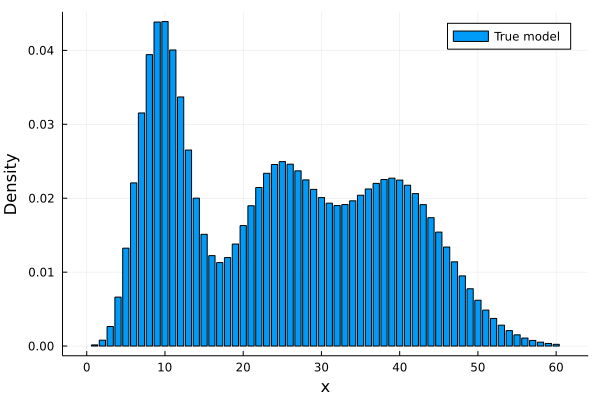

In [3]:
bar(x -> pdf(true_model, x), 1:60, label="True model", xlabel="x", ylabel="Density")

## 観測データを生成

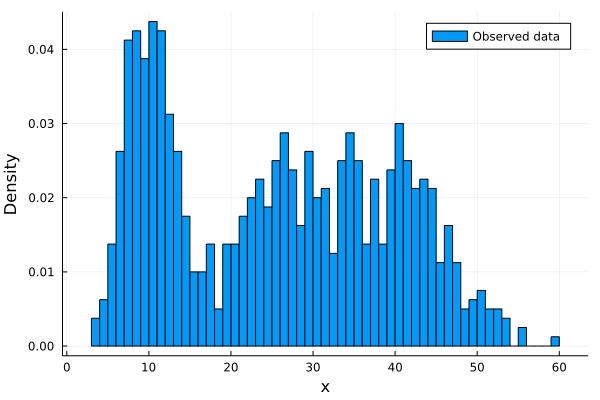

In [4]:
N = 800
mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

data = Float64[]
for (idx, val) in enumerate(λ_true)
    n = count(cluster_num .== idx)
    poi_obs = Poisson(val)
    data = vcat(data, rand(poi_obs, n))
end

bins = 80
histogram(data; bins, label="Observed data", xlabel="x", ylabel="Density", norm=:pdf)

## 崩壊型ギブスサンプリング

In [5]:
N = 800
K = 3
max_iter = 100

â = ones(K)
b̂ = ones(K)
α̂ = ones(K)

s_sample = zeros(K, N)
â_sample = ones(max_iter, K)
b̂_sample = ones(max_iter, K)
α̂_sample = ones(max_iter, K)

# 潜在変数のサンプルに初期値を設定
E_π = α̂ ./ sum(α̂)
s_init = rand(Multinomial(1, E_π), N)

for i in 1:max_iter
    # パラメータの初期値を計算
    â += vec(sum(s_init .* data', dims=2))
    b̂ += vec(sum(s_init, dims=2))
    α̂ += vec(sum(s_init, dims=2))
    
    for n in 1:N
        # パラメータよりxₙに関する統計量を除去
        k = vec(mapslices(argmax, s_init, dims=1))[n]
        â[k] = â[k] - data[n]
        b̂[k] = b̂[k] - 1　# sₙₖ = 1
        α̂[k] = α̂[k] - 1
        
        # 潜在変数の事後分布を計算
        r̂ = â
        p̂ = 1 ./ (b̂ .+ 1)
        nb = NegativeBinomial.(r̂, 1 .- p̂)
        η = α̂ ./ sum(α̂)
        likehood = loglikelihood.(nb, data[n]) .+ log.(η)
        s_prob = vec(exp.(likehood) ./ sum(exp.(likehood))) # 正規化
                
        # 潜在変数をサンプリング
        cat = Multinomial(1, s_prob)
        s_sample[:, n] = rand(cat)
        
        # 新たに得られたxₙに関する統計量をパラメータに追加
        k = vec(mapslices(argmax, s_sample[:, n], dims=1))[1]
        â[k] = â[k] + data[n]
        b̂[k] = b̂[k] + 1
        α̂[k] = α̂[k] + 1
    end
    
    â_sample[i, :] = â
    b̂_sample[i, :] = b̂
    α̂_sample[i, :] = α̂
    
    fill!(â, one(eltype(â)))
    fill!(b̂, one(eltype(b̂)))
    fill!(α̂, one(eltype(α̂)))
    fill!(s_sample, zero(eltype(s_sample)))
    
    if i % 10 == 1
        println("iteration: $i")
    end
end

iteration: 1
iteration: 11
iteration: 21
iteration: 31
iteration: 41
iteration: 51
iteration: 61
iteration: 71
iteration: 81
iteration: 91


In [6]:
λ_sample = zeros(max_iter, K)
π_sample = zeros(max_iter, K)

for i in 1:max_iter
    for k in 1:K
        gam = Gamma(â_sample[i, k], 1 ./ b̂_sample[i, k])
        λ_sample[i, k] = rand(gam)[1]
    end
    dir = Dirichlet(α̂_sample[i, :])
    π_sample[i, :] = rand(dir) 
end

## サンプルしたパラメータを使って分布を確認

┌ Info: Saved animation to 
│   fn = /Users/akifumiabe/Julia/BayesMLBook/collapsed-gibbs-poisson.gif
└ @ Plots /Users/akifumiabe/.julia/packages/Plots/T6yvp/src/animation.jl:114


Plots.AnimatedGif("/Users/akifumiabe/Julia/BayesMLBook/collapsed-gibbs-poisson.gif")
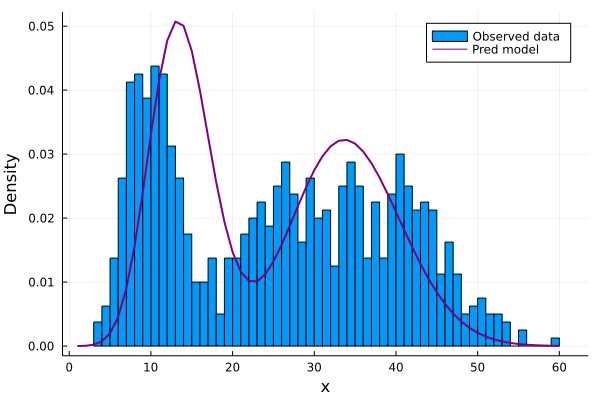

In [7]:
xs = 1:60
anim = @animate for i in 1:max_iter
    p = histogram(data; bins, norm=:pdf, label="Observed data", xlabel="x", ylabel="Density")
    d = MixtureModel([Poisson(λ) for λ in λ_sample[i, :]], π_sample[i, :])
    p = plot!(xs, pdf(d, xs), label="Pred model", linewidth=2, color="purple")
end

gif(anim, "collapsed-gibbs-poisson.gif", fps=10)

In [8]:
# 対数尤度の式から計算するパターン
#ln_nb = lnΓ.(r̂ .+ data[1]) .- log(factorial(data[1])) .- lnΓ.(r̂) .+ data[1] .* log.(1 .- p̂) .+ r̂ .* log.(p̂)
#ln_s_ = ln_nb .+ log.(η)
#ln_s = ln_s_ .- logsumexp(ln_s_)　# そのまま計算すると、アンダーフローで計算が不安定になるためlogsumexp()を使う
#prob_s_tmp2 = exp.(ln_s) ./ sum(exp.(ln_s))
#cat_tmp2 = Multinomial(1, prob_s_tmp2)
#s_1_tmp2 = rand(cat_tmp2)